# How well do two products agree?

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = data_dir
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

# Target Data

In [4]:
PER_BASIN = False

In [5]:
from scripts.cell_state.normalize import normalize_2d_dataset

if not "era5_ds" in globals().keys():
    filepath = data_dir / "camels_basin_ERA5Land_sm.nc"
    era5_ds = xr.open_dataset(filepath)

    if not isinstance(era5_ds, xr.Dataset):
        era5_ds = era5_ds.to_dataset()

    for var in era5_ds.data_vars:
        era5_ds[var] = normalize_2d_dataset(era5_ds, variable_str=var, per_basin=PER_BASIN)

    era5_ds["station_id"] = era5_ds["station_id"].astype(int)


if not "esa_ds" in globals().keys():
    filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
    esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
    if not isinstance(esa_ds, xr.Dataset):
        esa_ds = esa_ds.to_dataset()

    for var in esa_ds.data_vars:
        esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=PER_BASIN)

    esa_ds["station_id"] = esa_ds["station_id"].astype(int)
    
print(f"Loaded TARGET data with {'local' if PER_BASIN else 'global'} Normalisation")

Loaded TARGET data with global Normalisation


In [6]:
upper_soil = xr.merge([era5_ds["swvl1"], esa_ds["7_day_smooth_sm"]])
upper_soil = upper_soil.dropna("time", how="all")

# determine correlations

In [7]:
from scripts.read_nh_results import calculate_all_error_metrics

In [8]:
correlation = calculate_all_error_metrics(
    upper_soil,
    time_coord="time",
    basin_coord="station_id",
    obs_var="swvl1",
    sim_var="7_day_smooth_sm",
    metrics=["Pearson-r"]
)
correlation

Calculating Errors: 100%|██████████| 670/670 [01:47<00:00,  6.21it/s, 97002]


<xarray.Dataset>
Dimensions:     (station_id: 669)
Coordinates:
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
Data variables:
    Pearson-r   (station_id) float64 0.6611 0.3592 0.3425 ... 0.2141 0.3581

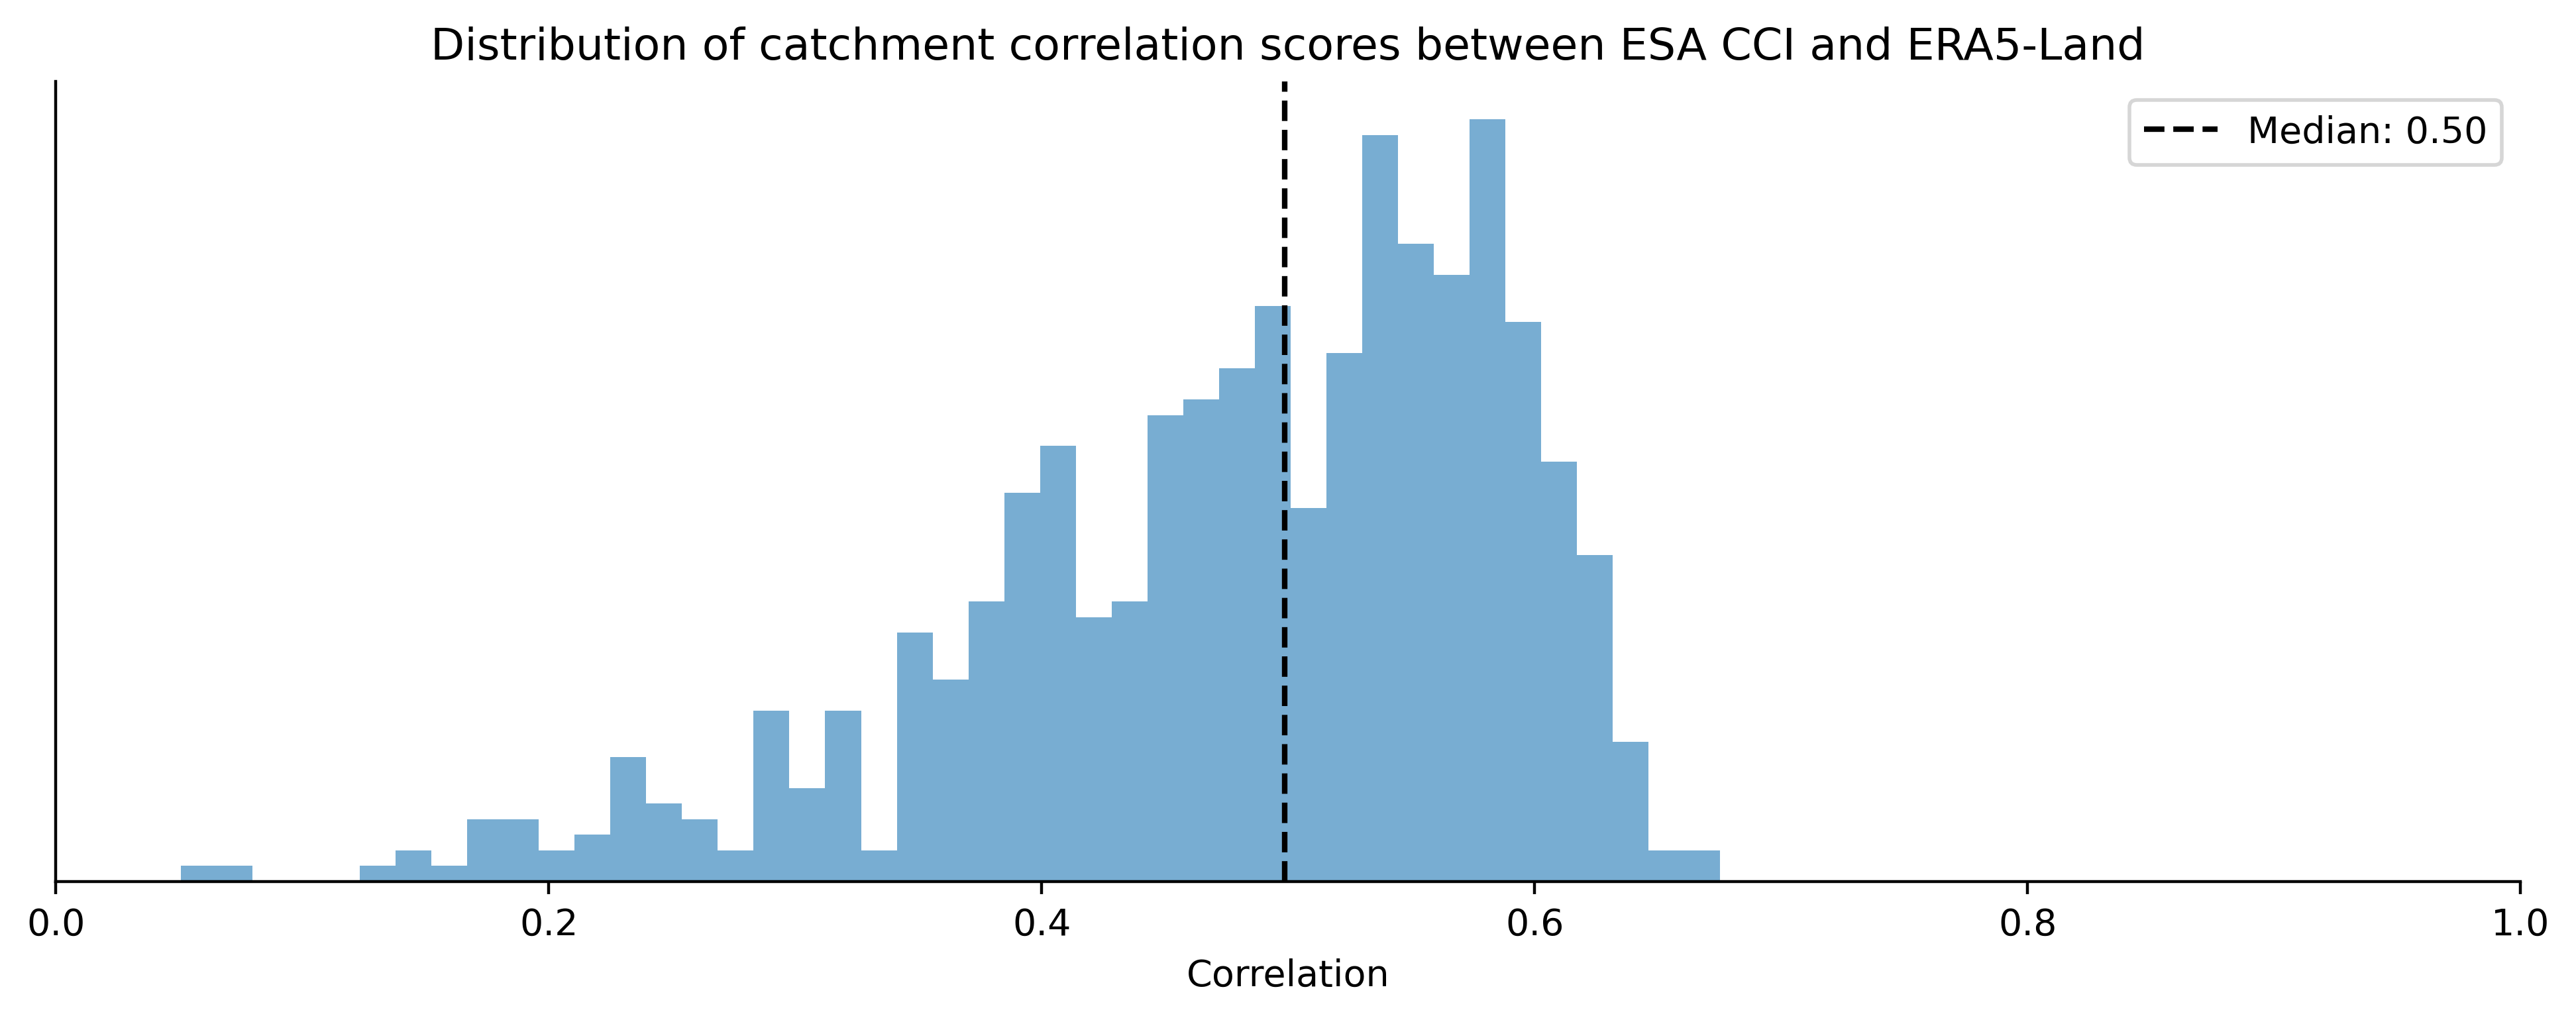

In [11]:
correlation.median()

with plt.rc_context({"figure.dpi": 400}):
    f, ax = plt.subplots(figsize=(12, 4))
    ax.hist(correlation["Pearson-r"].values, density=True, bins=50, alpha=0.6)
    med = correlation["Pearson-r"].median()
    ax.axvline(med, label=f"Median: {float(med):.2f}", color="k", ls="--")
    ax.set_xlim(0, 1)
    ax.set_xlabel("Correlation")
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title("Distribution of catchment correlation scores between ESA CCI and ERA5-Land")
    ax.legend()
    sns.despine()

# What do they look like overlain on map of GB?

In [68]:
esa = xr.open_dataset(data_dir / "esa_cci_sm_gb.nc")
esa_raw = esa["sm"].isel(time=0)
era5 = xr.open_dataset(data_dir / "gb_soil_moisture_1234_snow.nc")
era5_raw = era5["swvl1"].sel(time=esa_raw.time)
era5_raw.attrs = esa_raw.attrs

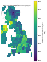

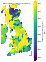

In [44]:
vmin = 0.22
vmax = 0.4

with plt.rc_context({"figure.dpi": 10}):
    ax = initialise_gb_spatial_plot()
    esa_raw.plot(ax=ax, vmin=vmin, vmax=vmax)
    date = (esa_raw["time"].values)
    ts = pd.to_datetime(str(date)) 
    d = ts.strftime('%Y/%m/%d')

    ax.set_title(f"ESA CCI Soil Moisture: {d}")
    
    ax = initialise_gb_spatial_plot()
    era5_raw.plot(ax=ax, vmin=vmin, vmax=vmax)
    date = (era5_raw["time"].values)
    ts = pd.to_datetime(str(date)) 
    d = ts.strftime('%Y/%m/%d')

    ax.set_title(f"ERA5-Land Soil Moisture (Level 1)\n{d}")

In [56]:
# how many fewer pixels?
print(era5_raw.shape)
print(esa_raw.shape)
print(np.product(era5_raw.shape))
print(np.product(esa_raw.shape))

np.product(era5_raw.shape) / np.product(esa_raw.shape)

(87, 93)
(35, 37)
8091
1295


6.247876447876448

In [72]:
print(f"ERA5 Range: {float(era5['swvl1'].min().values):.2f}: {float(era5['swvl1'].max().values):.2f}")
print(f"ESA CCI Range: {float(esa['sm'].min().values):.2f}: {float(esa['sm'].max().values):.2f}")

ERA5 Range: 0.03: 0.77
ESA CCI Range: 0.00: 0.57


# What static attribute with the catchment-correlation between products?